In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.regularizers import Regularizer
import pandas as pd
import numpy as np

In [3]:
print(tf.__version__)

2.8.0


In [4]:
# !pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [5]:
from IPython import display
from matplotlib import pyplot as plt

import pathlib
import shutil
import tempfile

In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/'tensorboard_logs'

In [7]:
shutil.rmtree(logdir, ignore_errors=True)

In [8]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [9]:
FEATURES = 28

In [10]:
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

Metal device set to: Apple M1


2022-06-29 10:05:20.740325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-29 10:05:20.740713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [26]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

In [30]:
a = packed_ds.batch(1).take(1)
a

<TakeDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


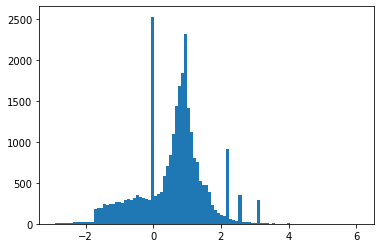

In [12]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN / BATCH_SIZE

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.take(N_TRAIN).cache()
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [15]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

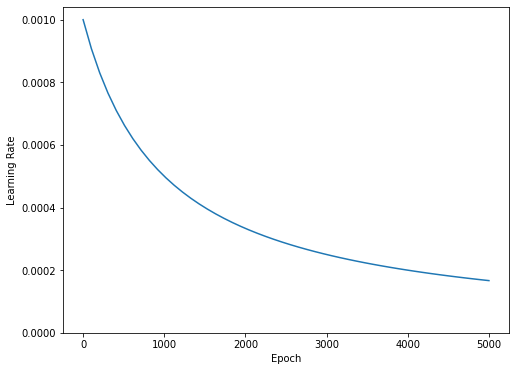

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [17]:
def get_optimizer():
    return Adam(lr_schedule)

In [18]:
def get_callbacks(name):
    return [
          tfdocs.modeling.EpochDots(),
          tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
          tf.keras.callbacks.TensorBoard(logdir/name)
    ]

In [19]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                loss=BinaryCrossentropy(from_logits=True),
                metrics=[BinaryCrossentropy(from_logits=True,
                                            name='binary_crossentropy'),
                         'accuracy']
    )

    model.summary()

    history = model.fit(train_ds,
                      steps_per_epoch = STEPS_PER_EPOCH,
                      epochs=max_epochs,
                      validation_data=validate_ds,
                      callbacks=get_callbacks(name),
                      verbose=0)
    return history

In [20]:
tiny_model = tf.keras.Sequential([
    Dense(16, activation='elu', input_shape=(FEATURES,)),
    Dense(1)
])

In [21]:
size_histories = {}

In [22]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4713,  binary_crossentropy:0.8059,  loss:0.8059,  val_accuracy:0.4710,  val_binary_crossentropy:0.7750,  val_loss:0.7750,  
....................................................................................................
Epoch: 100, accuracy:0.5958,  binary_crossentropy:0.6302,  loss:0.6302,  val_accuracy:0.5890,  val_binary_crossentropy:0.6173,  val_loss:0.6173,  
............................................................

....................................................................................................
Epoch: 3100, accuracy:0.6940,  binary_crossentropy:0.5603,  loss:0.5603,  val_accuracy:0.7150,  val_binary_crossentropy:0.5289,  val_loss:0.5289,  
....................................................................................................
Epoch: 3200, accuracy:0.6950,  binary_crossentropy:0.5595,  loss:0.5595,  val_accuracy:0.7160,  val_binary_crossentropy:0.5280,  val_loss:0.5280,  
....................................................................................................
Epoch: 3300, accuracy:0.6925,  binary_crossentropy:0.5596,  loss:0.5596,  val_accuracy:0.7100,  val_binary_crossentropy:0.5286,  val_loss:0.5286,  
....................................................................................................
Epoch: 3400, accuracy:0.6892,  binary_crossentropy:0.5595,  loss:0.5595,  val_accuracy:0.7180,  val_binary_crossentropy:0.5278,  val_loss:0.5278,  
....

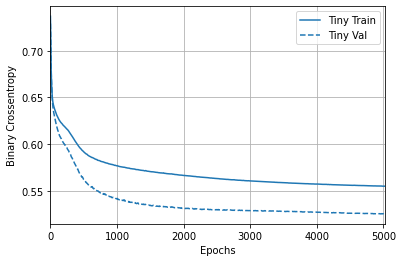

In [23]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)

In [27]:
size_histories['Tiny'].history.key()

AttributeError: 'dict' object has no attribute 'key'

In [2]:
a = '....................................................................................................'

In [3]:
counts = 0
for i in a:
    if a[i] == '.':
        counts += 1
counts

TypeError: string indices must be integers

100